In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns # for beautiful graphs
import scipy.stats as stats # to calculate r^2 for linear regressions
from scipy.stats import powerlaw # for plotting linear regressions
import statsmodels as sm
import matplotlib.ticker as mtick
import re
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [7]:
#opening the data
data= pd.read_csv('clean_dataset.csv',delimiter=',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis=1,inplace=True)


In [8]:
#show the dataframe
display(data.head(3))

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,60647.0,2019-10-23,Canvass,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ..."
1,2320261,CRAZY BIRD,CRAZY BIRD,2616198.0,Restaurant,Risk 1 (High),1160 W GRAND AVE,60642.0,2019-10-22,Canvass,Pass w/ Conditions,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,41.891193,-87.657055,"{'longitude': '41.891193484441246', 'latitude'..."
2,2320298,HAISOUS,CA PHE DA,2464411.0,Restaurant,Risk 1 (High),1800-1802 S CARPENTER ST,60608.0,2019-10-22,Canvass,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.857963,-87.653358,"{'longitude': '41.8579631274509', 'latitude': ..."


# Violation characterization 

In [89]:
#function that split the violations number from the comments

def violation_separator(violations):
    
    #creating an empty dataframe in order to stock the violation numbers
    violation_number = pd.Series([]) 
    
    if type(violations) == str:
        #each different violation is separated by a ' | ' in a dataframe cell
        violations = violations.split(' | ') 
        
        for violation in violations: 
            #the index refers to the violation number
            index = "#" + violation.split('.')[0] 
            #add 1 if there is a violation #.. and 0 if not.
            violation_number[index] = 1
            
    return violation_number

In [417]:
# function that take a data with  violations by number and categorize them and count then by category
def Violations_Dataframe (separated_data, basic_data): 
    
    '''
    Count violations by category
    
    Parameters
    ----------
    separated_data: pandas.DataFrame
        DataFrame with separated violations
    
    basic_data: pandas.DataFrame
        DataFrame with the original data
        
    Returns 
    -------
    violation_data: pandas.DataFrame
        DataFrame with truth table for the violations (if they occured(1) or not(0))
    
    violation_counts: pandas.DataFrame
        DataFrame with grouped violations 
    
    '''
    
    #columns creation 
    critical = [("#" + str(num)) for num in range(1, 15)]
    serious = [("#" + str(num)) for num in range(15, 30)]
    minor = [("#" + str(num)) for num in range(30, 45)]
    minor.append("#70")

    # Create complete list of column names
    columns = critical + serious + minor

    # Create dataframe using column names, violation data and inspection ID
    violations_data = pd.DataFrame(separated_data, columns=columns)
    violations_data['inspection_id'] = basic_data.inspection_id
    violations_data['license'] = basic_data.license
    violations_data['inspection_type'] = basic_data.inspection_type
    #violations_data['zip']== basic_data.zip
    
    violation_counts = pd.DataFrame({
    "critical_count": violations_data[critical].sum(axis=1),
    "serious_count": violations_data[serious].sum(axis=1),
    "minor_count": violations_data[minor].sum(axis=1)
    })

    violation_counts['inspection_id'] = basic_data.inspection_id
   
    
    #violation_counts['license'] = basic_data.license
    #violation_counts['zip'] = basic_data.zip
    #violation_counts['risk'] = basic_data.risk
    #violation_counts['results'] = basic_data.results
    #violation_counts['inspection_type'] = basic_data.inspection_type
    #violation_counts['inspection_date'] = basic_data.inspection_date
    #violation_counts['facility_type'] = basic_data.facility_type
    
    
    # Display selection of sums dataframe
    violation_counts.iloc[3:6]
    
    violation_counts = basic_data.merge(violation_counts, on = ['inspection_id'])
        
    #calculation of the proportion of type of count in order to normalize this variable.
    violation_counts['violations_count'] = violation_counts.critical_count + violation_counts.serious_count+violation_counts.minor_count
    
    #we ajust the count in order to have a proportion
    violation_counts['critical_count']=violation_counts['critical_count'].divide(violation_counts["violations_count"])
    violation_counts['serious_count']=violation_counts['serious_count'].divide(violation_counts["violations_count"])
    violation_counts['minor_count']=violation_counts['minor_count'].divide(violation_counts["violations_count"])
    
    violation_counts.fillna(0,inplace=True)
    
    
    return violations_data,violation_counts 

In [147]:
#We apply this functions to our basic data 
violation_separated= data.violations.apply(violation_separator).fillna(0)

In [418]:
#we create our dataframe with all the violations counts
violations_df,violations_dataframe=Violations_Dataframe(violation_separated,data)


In [438]:
violations_dataframe.head(5)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,critical_count,serious_count,minor_count,violations_count
0,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,60647.0,2019-10-23,Canvass,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",0.000000,0.666667,0.333333,3.0
1,2320261,CRAZY BIRD,CRAZY BIRD,2616198.0,Restaurant,Risk 1 (High),1160 W GRAND AVE,60642.0,2019-10-22,Canvass,Pass w/ Conditions,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,41.891193,-87.657055,"{'longitude': '41.891193484441246', 'latitude'...",0.000000,0.666667,0.333333,3.0
2,2320298,HAISOUS,CA PHE DA,2464411.0,Restaurant,Risk 1 (High),1800-1802 S CARPENTER ST,60608.0,2019-10-22,Canvass,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.857963,-87.653358,"{'longitude': '41.8579631274509', 'latitude': ...",0.000000,0.000000,0.000000,0.0
3,2320293,HARMONY RESTAURANT,HARMONY RESTAURANT,61757.0,Restaurant,Risk 1 (High),6525 W ARCHER AVE,60638.0,2019-10-22,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.792164,-87.785406,"{'longitude': '41.792163848654795', 'latitude'...",0.000000,0.000000,1.000000,1.0
4,2320229,HIMALAYAN SHERPA KITCHEN,HIMALAYAN SHERPA KITCHEN,2670751.0,Restaurant,Risk 1 (High),2701 W LAWRENCE AVE,60625.0,2019-10-22,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.968442,-87.696304,"{'longitude': '41.968442053562335', 'latitude'...",0.333333,0.333333,0.333333,3.0


# Food Poisoning Analysis

In [420]:
food_poisoning_df=violations_df.loc[violations_dataframe['inspection_type']== 'Suspected Food Poisoning']

In [421]:
food_poisoning_df.head(3)

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#39,#40,#41,#42,#43,#44,#70,inspection_id,license,inspection_type
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2315831,37212.0,Suspected Food Poisoning
513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2312966,2428838.0,Suspected Food Poisoning
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2312427,16310.0,Suspected Food Poisoning


In [422]:
# Import violation titles
titles = pd.read_csv("liste_colonnes.csv",delimiter=';')
food_poisoning_df.rename(columns=titles.iloc[0],inplace=True)


In [423]:
# Sum binary values for each violation
sums = food_poisoning_df.drop(["inspection_id","license",'inspection_type'],axis=1).sum()

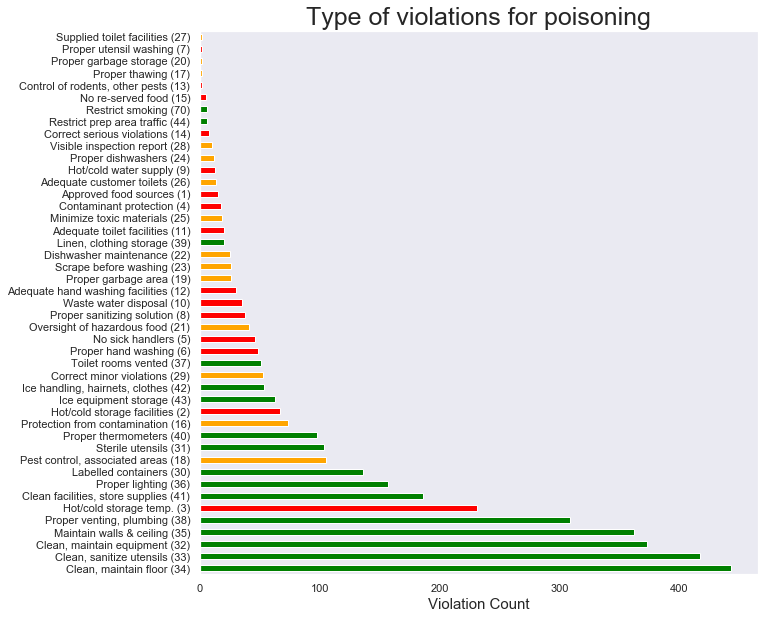

In [424]:
# Generate color list
colors = ["red"] *15  + ["orange"] *14  + ["green"] *16 

# Sort sums and colors by sum value
sum_data = pd.DataFrame({"sums": sums, "colors": colors}).sort_values("sums")

# Plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data.sums.plot(kind="barh", color=sum_data.colors)
ax.set_title("Type of violations for poisoning", fontsize=25)
ax.set_xlabel("Violation Count", fontsize=15)
ax.invert_yaxis()
plt.show()

> Critical factors that seems to cause food poisoning :*hot/cold storage temp/facilities* and *hand washing*.

>Serious factors : *pest control* and *protection from contamination*

## Comparison with other inspections

In [425]:
other_inspections_df=violations_df.loc[violations_dataframe['inspection_type']!= 'Suspected Food Poisoning']

In [426]:
other_inspections_df.rename(columns=titles.iloc[0],inplace=True)
# Sum binary values for each violation
sums_other = other_inspections_df.drop(["inspection_id","license",'inspection_type'],axis=1).sum()

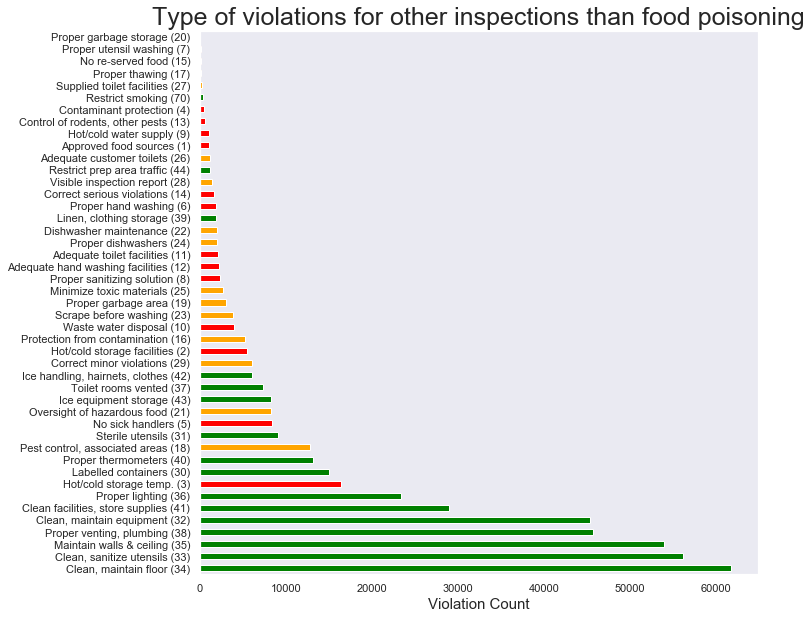

In [427]:
# Generate color list
colors = ["red"] *15  + ["orange"] *14  + ["green"] *16 

# Sort sums and colors by sum value
sum_data_other = pd.DataFrame({"sums": sums_other, "colors": colors}).sort_values("sums")

# Plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data_other.sums.plot(kind="barh", color=sum_data_other.colors)
ax.set_title("Type of violations for other inspections than food poisoning", fontsize=25)
ax.set_xlabel("Violation Count", fontsize=15)
ax.invert_yaxis()
plt.show()

> We still observe the same major critical violation which is due to hot/col temperature storage. 

In [428]:
violation_number=sum_data_other['sums'].sum()
sum_data_other['proportion']=sum_data_other['sums'].divide(violation_number)*100
sum_data_other=sum_data_other.sort_values('proportion',ascending=False)

print('\n\033[1m Violations for other inspection than food poisoning \033[0m')
display(sum_data_other)



 Violations for other inspection than food poisoning 


,sums,colors,proportion
"Clean, maintain floor (34)",61720.0,green,13.012285
"Clean, sanitize utensils (33)",56107.0,green,11.828909
Maintain walls & ceiling (35),53911.0,green,11.365932
"Proper venting, plumbing (38)",45627.0,green,9.619435
"Clean, maintain equipment (32)",45336.0,green,9.558084
"Clean facilities, store supplies (41)",29010.0,green,6.116111
Proper lighting (36),23391.0,green,4.931470
Hot/cold storage temp. (3),16380.0,red,3.453358
Labelled containers (30),14984.0,green,3.159042
Proper thermometers (40),13134.0,green,2.769011


> We need to merge the dataframe.

In [429]:
violation_number=sum_data['sums'].sum()
sum_data['proportion']=sum_data['sums'].divide(violation_number)*100
sum_data=sum_data.sort_values('proportion',ascending=False)
print('\n\033[1m Violations for inspections due to food poisoning \033[0m')
display(sum_data)



 Violations for inspections due to food poisoning 


,sums,colors,proportion
"Clean, maintain floor (34)",443.0,green,11.735099
"Clean, sanitize utensils (33)",417.0,green,11.046358
"Clean, maintain equipment (32)",373.0,green,9.880795
Maintain walls & ceiling (35),362.0,green,9.589404
"Proper venting, plumbing (38)",309.0,green,8.185430
Hot/cold storage temp. (3),231.0,red,6.119205
"Clean facilities, store supplies (41)",186.0,green,4.927152
Proper lighting (36),157.0,green,4.158940
Labelled containers (30),136.0,green,3.602649
"Pest control, associated areas (18)",105.0,orange,2.781457


In [430]:
comparison=pd.merge(sum_data,sum_data_other,left_index=True, right_index=True,suffixes =('_poisoning','_others')).sort_values('proportion_poisoning',ascending=False).reset_index()
del comparison['colors_others']
# Associate a number to each value of the feature
work_mapper = {'red':'critical','orange':'severe','green':'minor'}
# Replace them in the dataframe
comparison['colors_poisoning'] = comparison['colors_poisoning'].replace(work_mapper)
comparison.rename(columns={'colors_poisoning': 'violation_type','index':'violations'}, inplace=True)

In [431]:
high_risk=comparison[comparison['proportion_poisoning']>comparison['proportion_others']]
high_risk['ratio']=high_risk['proportion_poisoning'].divide(high_risk['proportion_others'])
high_risk.sort_values('ratio',ascending=False)

,violations,sums_poisoning,violation_type,proportion_poisoning,sums_others,proportion_others,ratio
30,Contaminant protection (4),18.0,critical,0.476821,468.0,0.098667,4.832613
39,No re-served food (15),5.0,critical,0.132450,132.0,0.027829,4.759392
18,Proper hand washing (6),49.0,critical,1.298013,1842.0,0.388345,3.342426
41,Proper garbage storage (20),2.0,severe,0.052980,82.0,0.017288,3.064584
42,Proper utensil washing (7),2.0,critical,0.052980,120.0,0.025299,2.094132
21,Proper sanitizing solution (8),38.0,critical,1.006623,2323.0,0.489753,2.055369
38,Restrict smoking (70),6.0,minor,0.158940,378.0,0.079693,1.994412
40,Proper thawing (17),2.0,severe,0.052980,135.0,0.028462,1.861451
5,Hot/cold storage temp. (3),231.0,critical,6.119205,16380.0,3.453358,1.771958
12,Protection from contamination (16),74.0,severe,1.960265,5300.0,1.117387,1.754330
